In [31]:
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import scienceplots

In [32]:
df1 = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_compared.tsv', sep='\t')
df2 = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')
df3 = pd.read_csv('./project_pipeline/data/ai_cluster_interface.tsv', sep='\t')
df4 = pd.read_csv('./project_pipeline/data/alphafold_interface.tsv', sep='\t')
df5 = pd.read_csv('./project_pipeline/data/proteins_interface.tsv', sep='\t')
ai_dockq = pd.read_csv('./project_pipeline/data/ai_pdb_full_depth_dockq.csv')
md_dockq = pd.read_csv('./project_pipeline/data/md_pdb_full_depth_dockq.csv')
cf_dockq = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_dockq.csv')

In [33]:
# Add uniprot to cf_dockq
uniprot = df2[['uniprot', 'pdb']].drop_duplicates().reset_index(drop=True)
cf_dockq = pd.merge(uniprot, cf_dockq, on='pdb', how='inner')
cf_dockq.columns

Index(['uniprot', 'pdb', 'cluster', 'fnat', 'fnat_correct', 'fnat_total',
       'fnonnat', 'fnonnat_nnative', 'fnonnat_model', 'irms', 'lrms', 'dockq',
       'capri'],
      dtype='object')

## Getting the Statistics

In [34]:
df1.head()

,uniprot,pdb,cluster,region_1,region_2,complex_rmsd,1.0_aligned,1.0_comp,1.1_aligned,1.1_comp,...,2.1_aligned,2.1_comp,2.2_aligned,2.2_comp,2.3_aligned,2.3_comp,1_aligned,1_comp,2_aligned,2_comp
0,P04637,8f2h,004,364-393,102-292,28.339,12.404,82.016,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,12.404,82.016,5.799,63.920
1,P04637,8f2h,000,364-393,102-292,31.787,14.986,73.026,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,14.986,73.026,10.254,95.323
2,P04637,8f2h,015,364-393,102-292,26.456,12.146,74.410,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,12.146,74.410,4.941,35.216
3,P04637,8f2h,009,364-393,102-292,27.241,11.443,76.759,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,11.443,76.759,10.518,51.250
4,P04637,8f2h,U100-003,364-393,102-292,34.649,13.018,84.822,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,13.018,84.822,3.235,98.816


The state and conformation information in two-state_cf_pdb_compared is the experimental state and conformation.

In [35]:
df1 = df1.rename(columns={'state': 'pdb_state', 'conformation': 'pdb_conformation', 'complex_rmsd': 'cf_pdb_complex_rmsd', '2_comp': 'cf_pdb_IMAE'})
df1_sub = df1[['uniprot', 'pdb', 'cluster', 'cf_pdb_complex_rmsd', 'cf_pdb_IMAE']]
# Remove any uniformly sampled clusters
df1_sub = df1_sub[~df1_sub['cluster'].str.contains('U')]
print('The length of the df1_sub is:', len(df1_sub))
print('The number of unique uniprot in df1_sub is:', len(df1_sub['uniprot'].unique()))
print('The number of unique pdb in df1_sub is:', len(df1_sub['pdb'].unique()))
df1_sub.head()

The length of the df1_sub is: 58852
The number of unique uniprot in df1_sub is: 34
The number of unique pdb in df1_sub is: 392


,uniprot,pdb,cluster,cf_pdb_complex_rmsd,cf_pdb_IMAE
0,P04637,8f2h,004,28.339,63.920
1,P04637,8f2h,000,31.787,95.323
2,P04637,8f2h,015,26.456,35.216
3,P04637,8f2h,009,27.241,51.250
6,P04637,8f2h,018,33.067,39.277


Get the pdb to Alphafold comparison data

In [36]:
df2 = df2.rename(columns={'state': 'pdb_state', 'conformation': 'pdb_conformation', 'complex_rmsd': 'af_pdb_complex_rmsd', '2_comp': 'af_pdb_IMAE'})
df2_sub = df2[['uniprot', 'pdb', 'pdb_state', 'pdb_conformation', 'af_pdb_complex_rmsd', 'af_pdb_IMAE']]
auto_uniprots = df2['uniprot'].unique()
print('The length of df2_sub is:', len(df2_sub))
df2_sub.head()

The length of df2_sub is: 894


,uniprot,pdb,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE
0,P04637,8f2h,Autoinhibited,Closed,30.431,70.729
1,P04637,8f2i,Autoinhibited,Closed,30.431,70.729
2,P07038,1mhs,Active,Closed,14.225,22.815
3,P07038,7nxf,Autoinhibited,Closed,4.914,12.107
4,P07038,7ny1,Autoinhibited,Closed,4.914,12.107


Join the first two dataframes together on only the shared proteins

In [37]:
cf_pdb_plus_af_pdb = pd.merge(df1_sub, df2_sub, on=['uniprot', 'pdb'], how='inner')
print('The length of cf_pdb_plus_af_pdb is:', len(cf_pdb_plus_af_pdb))
print('The number of unique uniprot in cf_pdb_plus_af_pdb is:', len(cf_pdb_plus_af_pdb['uniprot'].unique()))
print('The number of unique pdb in cf_pdb_plus_af_pdb is:', len(cf_pdb_plus_af_pdb['pdb'].unique()))
cf_pdb_plus_af_pdb.head()

The length of cf_pdb_plus_af_pdb is: 58852
The number of unique uniprot in cf_pdb_plus_af_pdb is: 34
The number of unique pdb in cf_pdb_plus_af_pdb is: 392


,uniprot,pdb,cluster,cf_pdb_complex_rmsd,cf_pdb_IMAE,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE
0,P04637,8f2h,004,28.339,63.920,Autoinhibited,Closed,30.431,70.729
1,P04637,8f2h,000,31.787,95.323,Autoinhibited,Closed,30.431,70.729
2,P04637,8f2h,015,26.456,35.216,Autoinhibited,Closed,30.431,70.729
3,P04637,8f2h,009,27.241,51.250,Autoinhibited,Closed,30.431,70.729
4,P04637,8f2h,018,33.067,39.277,Autoinhibited,Closed,30.431,70.729


We can get the alphafold and colabfold conformations from the interfaces

In [38]:
df3['cf_conformation'] = df3['number_interface_residues'].apply(lambda x: 'Closed' if x > 0 else 'Open')
df3_sub = df3[['uniprot', 'cluster', 'cf_conformation']]
df3_sub.head()

,uniprot,cluster,cf_conformation
0,P04637,004,Open
1,P04637,000,Open
2,P04637,015,Open
3,P04637,009,Open
4,P04637,U100-003,Open


Add this information to the dataframe

In [39]:
add_cf_conformation = pd.merge(cf_pdb_plus_af_pdb, df3_sub, on=['uniprot', 'cluster'], how='inner')
print('The length of add_cf_conformation is:', len(add_cf_conformation))
print('The number of unique uniprot in add_cf_conformation is:', len(add_cf_conformation['uniprot'].unique()))
print('The number of unique pdb in add_cf_conformation is:', len(add_cf_conformation['pdb'].unique()))
add_cf_conformation.head()

The length of add_cf_conformation is: 58852
The number of unique uniprot in add_cf_conformation is: 34
The number of unique pdb in add_cf_conformation is: 392


,uniprot,pdb,cluster,cf_pdb_complex_rmsd,cf_pdb_IMAE,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE,cf_conformation
0,P04637,8f2h,004,28.339,63.920,Autoinhibited,Closed,30.431,70.729,Open
1,P04637,8f2i,004,28.339,63.920,Autoinhibited,Closed,30.431,70.729,Open
2,P04637,8f2h,000,31.787,95.323,Autoinhibited,Closed,30.431,70.729,Open
3,P04637,8f2i,000,31.787,95.323,Autoinhibited,Closed,30.431,70.729,Open
4,P04637,8f2h,015,26.456,35.216,Autoinhibited,Closed,30.431,70.729,Open


Finally, add the Alphafold conformation

In [40]:
df4['af_conformation'] = df4['number_interface_residues'].apply(lambda x: 'Closed' if x > 0 else 'Open')
df4 = df4[df4['uniprot'].isin(auto_uniprots)]
df4_sub = df4[['uniprot', 'af_conformation']]
df4_sub.head()

,uniprot,af_conformation
3,P04637,Open
5,P00523,Closed
8,P28482,Closed
11,P62826,Closed
16,P43405,Closed


In [41]:
com = pd.merge(add_cf_conformation, df4_sub, on=['uniprot'], how='inner')
print('The length of com is:', len(com))
print('The number of unique uniprot in com is:', len(com['uniprot'].unique()))
print('The number of unique pdb in com is:', len(com['pdb'].unique()))
com.head()

The length of com is: 58852
The number of unique uniprot in com is: 34
The number of unique pdb in com is: 392


,uniprot,pdb,cluster,cf_pdb_complex_rmsd,cf_pdb_IMAE,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE,cf_conformation,af_conformation
0,P04637,8f2h,004,28.339,63.920,Autoinhibited,Closed,30.431,70.729,Open,Open
1,P04637,8f2i,004,28.339,63.920,Autoinhibited,Closed,30.431,70.729,Open,Open
2,P04637,8f2h,000,31.787,95.323,Autoinhibited,Closed,30.431,70.729,Open,Open
3,P04637,8f2i,000,31.787,95.323,Autoinhibited,Closed,30.431,70.729,Open,Open
4,P04637,8f2h,015,26.456,35.216,Autoinhibited,Closed,30.431,70.729,Open,Open


In [42]:
# Have to add unique ID for each cluster
com['cluster_id'] = com['uniprot'] + '_' + com['cluster']
com.head()

,uniprot,pdb,cluster,cf_pdb_complex_rmsd,cf_pdb_IMAE,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE,cf_conformation,af_conformation,cluster_id
0,P04637,8f2h,004,28.339,63.920,Autoinhibited,Closed,30.431,70.729,Open,Open,P04637_004
1,P04637,8f2i,004,28.339,63.920,Autoinhibited,Closed,30.431,70.729,Open,Open,P04637_004
2,P04637,8f2h,000,31.787,95.323,Autoinhibited,Closed,30.431,70.729,Open,Open,P04637_000
3,P04637,8f2i,000,31.787,95.323,Autoinhibited,Closed,30.431,70.729,Open,Open,P04637_000
4,P04637,8f2h,015,26.456,35.216,Autoinhibited,Closed,30.431,70.729,Open,Open,P04637_015


### Computing Statistics for All Structures

We want to know, how many of our experimental structures are in what conformations? And how many of our AlphaFold structures are in what conformations?

First, the experimental structures.

In [43]:
print(df2_sub['pdb_conformation'].value_counts())

Closed    862
Open       32
Name: pdb_conformation, dtype: int64


Next, the AlphaFold structures

In [44]:
print(df4['af_conformation'].value_counts())
print(len(df4['uniprot'].unique()))

Closed    115
Open       13
Name: af_conformation, dtype: int64
128


What are our best structures per protein?

In [45]:
best_exp = pd.merge(df2_sub, df4_sub, on=['uniprot'], how='inner')
best_per_prot = best_exp.groupby('uniprot')['af_pdb_IMAE'].idxmin()
best_exp = best_exp.loc[best_per_prot]
print('The length of best_exp is:', len(best_exp))
print(best_exp['pdb_conformation'].value_counts())

The length of best_exp is: 128
Closed    116
Open       12
Name: pdb_conformation, dtype: int64


In [46]:
best_exp_table = best_exp.groupby(['af_conformation'])['pdb_conformation'].value_counts()
best_exp_table

af_conformation  pdb_conformation
Closed           Closed              110
                 Open                  5
Open             Open                  7
                 Closed                6
Name: pdb_conformation, dtype: int64

In [47]:
best_exp_proteins = best_exp.groupby(['af_conformation', 'pdb_conformation'])['uniprot'].unique().unstack()
best_exp_proteins

pdb_conformation,Closed,Open
af_conformation,,
Closed,"[A0A0R4I961, B5XAZ0, D2AJU0, O00571, O08722, O...","[P46108, P53041, P54646, Q9NPP4, Q9Z0R4]"
Open,"[P04637, Q8NQJ3, Q8TCU6, Q96RD7, Q9BYP7, Q9Y490]","[P00579, P35609, P60240, Q07343, Q8R4B8, Q96P2..."


Which proteins have very large differences between structures?

In [48]:
diff = com
diff_min = com.groupby('uniprot')['af_pdb_IMAE'].min().reset_index()
diff_max = com.groupby('uniprot')['af_pdb_IMAE'].max().reset_index()
diff2 = pd.merge(diff_min, diff_max, on=['uniprot'], how='inner')
diff2['diff'] = diff2['af_pdb_IMAE_y'] - diff2['af_pdb_IMAE_x']
diff2 = diff2.rename(columns={'af_pdb_IMAE_x': 'min', 'af_pdb_IMAE_y': 'max'})
complex_min = diff.groupby('uniprot')['af_pdb_complex_rmsd'].min().reset_index()
diff2 = pd.merge(diff2, complex_min, on=['uniprot'], how='inner')
diff2.head(16)


,uniprot,min,max,diff,af_pdb_complex_rmsd
0,B5XAZ0,0.807,0.965,0.158,2.591
1,D2AJU0,7.860,7.860,0.000,3.539
2,O08967,1.593,54.034,52.441,3.115
3,O60741,1.290,2.148,0.858,1.182
4,O76074,3.791,3.890,0.099,3.048
5,P00523,3.093,3.093,0.000,1.737
6,P00579,45.352,51.763,6.411,13.459
7,P04637,70.729,70.729,0.000,30.431
8,P07038,12.107,22.815,10.708,4.914
9,P12931,2.074,47.288,45.214,1.254


In [49]:
diff10 = diff2[(diff2['diff'] > 10) & (diff2['min'] < 4.5)]
best_proteins = diff10['uniprot'].unique()

diff10

,uniprot,min,max,diff,af_pdb_complex_rmsd
2,O08967,1.593,54.034,52.441,3.115
9,P12931,2.074,47.288,45.214,1.254
11,P22681,1.498,34.316,32.818,1.351
12,P27577,4.394,14.492,10.098,3.953
14,P29350,1.765,57.427,55.662,1.444
33,Q9Y6K1,1.268,47.330,46.062,1.245


Get the pdbs for the min and max values per uniprot

In [50]:
arb = com[com['uniprot'].isin(best_proteins)]
arb

,uniprot,pdb,cluster,cf_pdb_complex_rmsd,cf_pdb_IMAE,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE,cf_conformation,af_conformation,cluster_id
49301,P12931,1fmk,029,23.757,44.936,Autoinhibited,Closed,1.857,7.045,Closed,Closed,P12931_029
49302,P12931,1ksw,029,23.513,47.735,Autoinhibited,Closed,1.767,5.018,Closed,Closed,P12931_029
49303,P12931,1y57,029,25.164,44.628,Active,Closed,24.076,47.288,Closed,Closed,P12931_029
49304,P12931,2h8h,029,24.074,51.095,Autoinhibited,Closed,1.346,2.700,Closed,Closed,P12931_029
49305,P12931,2src,029,23.891,48.057,Autoinhibited,Closed,1.693,5.354,Closed,Closed,P12931_029
...,...,...,...,...,...,...,...,...,...,...,...,...
57385,O08967,6bbq,019,19.663,44.521,Active,Closed,24.786,54.034,Closed,Closed,O08967_019
57386,O08967,2r09,014,16.173,29.663,Autoinhibited,Closed,3.179,1.593,Closed,Closed,O08967_014
57387,O08967,2r0d,014,16.164,29.185,Autoinhibited,Closed,3.115,1.619,Closed,Closed,O08967_014
57388,O08967,6bbp,014,18.551,31.881,Active,Closed,24.061,51.878,Closed,Closed,O08967_014


Add the DockQ scores to the dataframe

In [51]:
cf_dockq.columns

Index(['uniprot', 'pdb', 'cluster', 'fnat', 'fnat_correct', 'fnat_total',
       'fnonnat', 'fnonnat_nnative', 'fnonnat_model', 'irms', 'lrms', 'dockq',
       'capri'],
      dtype='object')

In [52]:
ai_dockq = ai_dockq.rename(columns={'fnat': 'ai_fnat', 'fnat_correct': 'ai_fnat_correct', 'fnat_total': 'ai_fnat_total',
                                    'fnonnat': 'ai_fnnonat', 'fnonnat_nnative': 'ai_fnonnat_native', 'fnonnat_model': 'ai_fnonnat_model',
                                    'irms': 'ai_irms', 'lrms': 'ai_lrms', 'dockq': 'ai_dockq', 'capri': 'ai_capri'})
cf_dockq = cf_dockq.rename(columns={'fnat': 'cf_fnat', 'fnat_correct': 'cf_fnat_correct', 'fnat_total': 'cf_fnat_total',
                                    'fnonnat': 'cf_fnnonat', 'fnonnat_nnative': 'cf_fnonnat_native', 'fnonnat_model': 'cf_fnonnat_model',
                                    'irms': 'cf_irms', 'lrms': 'cf_lrms', 'dockq': 'cf_dockq', 'capri': 'cf_capri'})

In [53]:
dockq = pd.merge(arb, ai_dockq, on=['uniprot', 'pdb'], how='inner')
dockq = pd.merge(dockq, cf_dockq, on=['uniprot', 'pdb', 'cluster'], how='inner')
dockq

,uniprot,pdb,cluster,cf_pdb_complex_rmsd,cf_pdb_IMAE,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE,cf_conformation,...,cf_fnat,cf_fnat_correct,cf_fnat_total,cf_fnnonat,cf_fnonnat_native,cf_fnonnat_model,cf_irms,cf_lrms,cf_dockq,cf_capri
0,P12931,1fmk,029,23.757,44.936,Autoinhibited,Closed,1.857,7.045,Closed,...,0.194,26.0,134.0,0.587,37.0,63.0,23.185,37.524,0.082,Incorrect
1,P12931,1fmk,152,24.991,46.352,Autoinhibited,Closed,1.857,7.045,Open,...,0.224,30.0,134.0,0.412,21.0,51.0,24.899,33.717,0.096,Incorrect
2,P12931,1fmk,170,27.745,53.789,Autoinhibited,Closed,1.857,7.045,Closed,...,0.090,12.0,134.0,0.739,34.0,46.0,28.983,46.480,0.042,Incorrect
3,P12931,1fmk,053,26.211,51.137,Autoinhibited,Closed,1.857,7.045,Closed,...,0.157,21.0,134.0,0.816,93.0,114.0,26.509,37.146,0.070,Incorrect
4,P12931,1fmk,071,27.521,49.359,Autoinhibited,Closed,1.857,7.045,Closed,...,0.149,20.0,134.0,0.583,28.0,48.0,28.031,31.189,0.074,Incorrect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,O08967,6bbq,027,21.988,64.399,Active,Closed,24.786,54.034,Closed,...,0.344,21.0,61.0,0.704,50.0,71.0,16.141,30.298,0.142,Incorrect
1786,O08967,6bbq,010,20.153,32.582,Active,Closed,24.786,54.034,Closed,...,0.311,19.0,61.0,0.721,49.0,68.0,17.472,29.185,0.132,Incorrect
1787,O08967,6bbq,036,26.510,47.941,Active,Closed,24.786,54.034,Closed,...,0.344,21.0,61.0,0.716,53.0,74.0,16.942,27.481,0.146,Incorrect
1788,O08967,6bbq,019,19.663,44.521,Active,Closed,24.786,54.034,Closed,...,0.459,28.0,61.0,0.594,41.0,69.0,14.473,27.021,0.187,Incorrect


Which experimental structures have the largest fnat (or largest number of true interface contacts in the model) per protein? And then how do their clusters compare?

In [54]:
ai_fnat_max = dockq.groupby('uniprot')['ai_fnat'].idxmax()
best_ai_dockq = dockq.loc[ai_fnat_max]
pd.set_option('display.max_columns', None)
best_ai_dockq

,uniprot,pdb,cluster,cf_pdb_complex_rmsd,cf_pdb_IMAE,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE,cf_conformation,af_conformation,cluster_id,ai_fnat,ai_fnat_correct,ai_fnat_total,ai_fnnonat,ai_fnonnat_native,ai_fnonnat_model,ai_irms,ai_lrms,ai_dockq,ai_capri,cf_fnat,cf_fnat_correct,cf_fnat_total,cf_fnnonat,cf_fnonnat_native,cf_fnonnat_model,cf_irms,cf_lrms,cf_dockq,cf_capri
1642,O08967,2r09,007,18.804,7.806,Autoinhibited,Closed,3.179,1.593,Closed,Closed,O08967_007,0.868,79.0,91.0,0.102,9.0,88.0,1.911,3.448,0.703,Medium,0.440,40.0,91.0,0.583,56.0,96.0,7.123,10.885,0.287,Acceptable
528,P12931,2h8h,029,24.074,51.095,Autoinhibited,Closed,1.346,2.700,Closed,Closed,P12931_029,0.958,114.0,119.0,0.073,9.0,123.0,0.668,0.978,0.926,High,0.227,27.0,119.0,0.571,36.0,63.0,23.290,37.233,0.094,Incorrect
1312,P22681,4a49,005,13.655,22.460,Active,Closed,1.351,1.498,Closed,Closed,P22681_005,0.947,36.0,38.0,0.077,3.0,39.0,0.771,1.214,0.906,High,0.132,5.0,38.0,0.583,7.0,12.0,13.013,17.563,0.111,Incorrect
1514,P27577,1md0,029,14.056,27.263,Active,Closed,9.778,14.492,Closed,Closed,P27577_029,0.923,60.0,65.0,0.231,18.0,78.0,9.167,10.084,0.455,Acceptable,0.169,11.0,65.0,0.814,48.0,59.0,14.987,23.969,0.097,Incorrect
1475,P29350,3ps5,018,14.906,49.316,Active,Closed,1.444,1.765,Open,Closed,P29350_018,0.884,61.0,69.0,0.187,14.0,75.0,0.954,1.224,0.859,High,0.087,6.0,69.0,0.842,32.0,38.0,15.148,37.978,0.048,Incorrect
1434,Q9Y6K1,4u7t,000,23.244,56.151,Active,Closed,1.245,1.268,Closed,Closed,Q9Y6K1_000,0.904,66.0,73.0,0.108,8.0,74.0,0.513,0.830,0.930,High,0.068,5.0,73.0,0.737,14.0,19.0,26.181,50.966,0.033,Incorrect


In [55]:
cf_fnat_max = dockq.groupby('uniprot')['cf_fnat'].idxmax()
best_cf_dockq = dockq.loc[cf_fnat_max]
best_cf_dockq

,uniprot,pdb,cluster,cf_pdb_complex_rmsd,cf_pdb_IMAE,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE,cf_conformation,af_conformation,cluster_id,ai_fnat,ai_fnat_correct,ai_fnat_total,ai_fnnonat,ai_fnonnat_native,ai_fnonnat_model,ai_irms,ai_lrms,ai_dockq,ai_capri,cf_fnat,cf_fnat_correct,cf_fnat_total,cf_fnnonat,cf_fnonnat_native,cf_fnonnat_model,cf_irms,cf_lrms,cf_dockq,cf_capri
1772,O08967,6bbq,011,24.506,56.660,Active,Closed,24.786,54.034,Closed,Closed,O08967_011,0.426,26.0,61.0,0.759,82.0,108.0,17.138,32.668,0.166,Incorrect,0.541,33.0,61.0,0.676,69.0,102.0,19.855,33.370,0.203,Incorrect
1132,P12931,7yqe,061,1.608,2.634,Autoinhibited,Closed,2.092,6.031,Closed,Closed,P12931_061,0.933,14.0,15.0,0.000,0.0,14.0,0.803,3.226,0.862,High,1.000,15.0,15.0,0.000,0.0,15.0,0.819,1.436,0.914,High
1354,P22681,4a4c,001,19.745,22.083,Active,Closed,1.370,2.208,Closed,Closed,P22681_001,0.826,38.0,46.0,0.191,9.0,47.0,1.107,1.838,0.810,High,0.304,14.0,46.0,0.622,23.0,37.0,18.067,22.096,0.147,Incorrect
1617,P27577,6dat,024,8.034,14.128,Active,Closed,8.363,14.391,Closed,Closed,P27577_024,0.882,60.0,68.0,0.211,16.0,76.0,7.867,10.954,0.431,Acceptable,0.529,36.0,68.0,0.446,29.0,65.0,6.505,7.920,0.372,Acceptable
1438,P29350,2b3o,004,7.254,7.168,Autoinhibited,Closed,25.878,57.427,Closed,Closed,P29350_004,0.062,6.0,96.0,0.914,64.0,70.0,20.891,54.387,0.030,Incorrect,0.198,19.0,96.0,0.596,28.0,47.0,5.624,11.414,0.207,Incorrect
1432,Q9Y6K1,4u7p,000,28.315,72.153,Autoinhibited,Closed,15.705,47.330,Closed,Closed,Q9Y6K1_000,0.373,28.0,75.0,0.711,69.0,97.0,16.426,44.887,0.139,Incorrect,0.173,13.0,75.0,0.552,16.0,29.0,28.813,70.663,0.063,Incorrect


### Looking at the Distribution of Interface Contacts

In [58]:
df5.head()
df5_sub = df5[['uniprot', 'pdb', 'number_interface_residues']]
to_hist = pd.merge(com, df5_sub, on=['uniprot', 'pdb'], how='inner')
to_hist = to_hist.drop(columns=['cluster', 'cf_pdb_complex_rmsd', 'cf_pdb_IMAE', 'cluster_id', 'cf_conformation']).drop_duplicates().reset_index(drop=True).fillna(0)
to_hist.head()

,uniprot,pdb,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE,af_conformation,number_interface_residues
0,P04637,8f2h,Autoinhibited,Closed,30.431,70.729,Open,21.0
1,P04637,8f2i,Autoinhibited,Closed,30.431,70.729,Open,21.0
2,P07038,1mhs,Active,Closed,14.225,22.815,Closed,18.0
3,P07038,7nxf,Autoinhibited,Closed,4.914,12.107,Closed,26.0
4,P07038,7ny1,Autoinhibited,Closed,4.914,12.107,Closed,26.0


In [59]:
zero = to_hist[to_hist['number_interface_residues'] == 0]
zero.head()

,uniprot,pdb,pdb_state,pdb_conformation,af_pdb_complex_rmsd,af_pdb_IMAE,af_conformation,number_interface_residues
6,Q8NQJ3,2kb4,Active,Open,30.770,61.982,Open,0.0
7,P00579,4llg,Active,Open,13.459,45.352,Open,0.0
8,P00579,4lk1,Active,Open,13.988,46.737,Open,0.0
9,P00579,7khi,Active,Open,18.080,51.763,Open,0.0
10,P00579,4zh2,Active,Open,13.987,46.736,Open,0.0


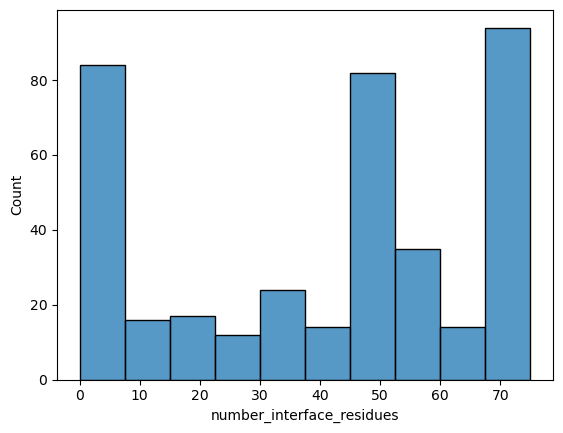

In [60]:
f = sns.histplot(data=to_hist, x='number_interface_residues')

### Computing the Statistics for Two-State proteins


First, just some numbers. How many Alphafold structures are in the open conformation vs the closed conformation? How about colabfold?

In [61]:
# First the AlphaFold conformations
af_conformation = com[['uniprot', 'af_conformation']].drop_duplicates().reset_index(drop=True)
print(af_conformation['af_conformation'].value_counts())

Closed    30
Open       4
Name: af_conformation, dtype: int64


In [62]:
# Next the experimental conformations
pdb_conformation = com[['uniprot', 'pdb', 'pdb_conformation']].drop_duplicates().reset_index(drop=True)
print(pdb_conformation['pdb_conformation'].value_counts())

Closed    384
Open        8
Name: pdb_conformation, dtype: int64


In [63]:
# Next, our clusters
cf_conformation = com[['uniprot', 'cluster_id', 'cf_conformation']].drop_duplicates().reset_index(drop=True)
cf_val = cf_conformation['cf_conformation'].value_counts()
cf_val

Closed    2135
Open       266
Name: cf_conformation, dtype: int64

### Cross-tabs

Now let's look at how many of our experimental structures are closed while their Alphafold structures are open, and vice versa.

First we'll have to rename everything

In [64]:
com = com.rename(columns={'pdb_conformation': 'Experimental Conformation', 'af_conformation': 'Full-Depth Conformation', 'cf_conformation': 'Cluster Conformation'})

In [65]:
af_vs_pdb = com[['uniprot', 'pdb', 'Full-Depth Conformation', 'Experimental Conformation']].drop_duplicates().reset_index(drop=True)
af_vs_pdbg = af_vs_pdb.groupby(['Full-Depth Conformation', 'Experimental Conformation']).size().unstack().fillna(0)
avp_uniprot = af_vs_pdb.groupby(['uniprot'])['Experimental Conformation'].value_counts()
avp = avp_uniprot.unstack(fill_value=0).reset_index()

avp.columns.name = None
avp = avp.rename(columns={'Closed': 'Closed Experimental', 'Open': 'Open Experimental'})

avp.head(16)

,uniprot,Closed Experimental,Open Experimental
0,B5XAZ0,2,0
1,D2AJU0,1,0
2,O08967,4,0
3,O60741,4,0
4,O76074,2,0
5,P00523,1,0
6,P00579,0,6
7,P04637,2,0
8,P07038,3,0
9,P12931,7,0


Let's look at the breakdown for cluster structures

In [66]:
af_vs_cf = com[['uniprot', 'cluster_id', 'Full-Depth Conformation', 'Cluster Conformation']].drop_duplicates().reset_index(drop=True)
af_vs_cfg = af_vs_cf.groupby(['Full-Depth Conformation', 'Cluster Conformation']).size().unstack().fillna(0)
avc_uniprot = af_vs_cf.groupby(['uniprot'])['Cluster Conformation'].value_counts()
avc = avc_uniprot.unstack(fill_value=0).reset_index()

avc.columns.name = None
avc = avc.rename(columns={'Closed': 'Closed Cluster', 'Open': 'Open Cluster'})

avc.head(16)

,uniprot,Closed Cluster,Open Cluster
0,B5XAZ0,121,0
1,D2AJU0,15,9
2,O08967,36,1
3,O60741,1,0
4,O76074,10,3
5,P00523,139,22
6,P00579,0,6
7,P04637,1,23
8,P07038,0,3
9,P12931,146,30


What about cross tabs for all of them?

In [67]:
all_conformations = com[['uniprot', 'pdb', 'cluster_id', 'Full-Depth Conformation', 'Experimental Conformation', 'Cluster Conformation']].drop_duplicates().reset_index(drop=True)
all_conformations = all_conformations.groupby(['uniprot', 'Full-Depth Conformation', 'Experimental Conformation'])['Cluster Conformation'].value_counts()
all_conformations.unstack()

,,Cluster Conformation,Closed,Open
uniprot,Full-Depth Conformation,Experimental Conformation,,
B5XAZ0,Closed,Closed,242.0,NaN
D2AJU0,Closed,Closed,15.0,9.0
O08967,Closed,Closed,144.0,4.0
O60741,Closed,Closed,4.0,NaN
O76074,Closed,Closed,20.0,6.0
P00523,Closed,Closed,139.0,22.0
P00579,Open,Open,NaN,36.0
P04637,Open,Closed,2.0,46.0
P07038,Closed,Closed,NaN,9.0


Make a Full-Depth Count Table

In [68]:
af = com[['uniprot', 'Full-Depth Conformation']].drop_duplicates().reset_index(drop=True)
af = af.groupby(['uniprot'])['Full-Depth Conformation'].value_counts()
af = af.unstack(fill_value=0).reset_index()

af.columns.name = None
af = af.rename(columns={'Closed': 'Closed Full-Depth', 'Open': 'Open Full-Depth'})
af.head(16)

,uniprot,Closed Full-Depth,Open Full-Depth
0,B5XAZ0,1,0
1,D2AJU0,1,0
2,O08967,1,0
3,O60741,1,0
4,O76074,1,0
5,P00523,1,0
6,P00579,0,1
7,P04637,0,1
8,P07038,1,0
9,P12931,1,0


In [69]:
first = pd.merge(af, avp, on=['uniprot'], how='inner')
full = pd.merge(first, avc, on=['uniprot'], how='inner')

full.head(16)

,uniprot,Closed Full-Depth,Open Full-Depth,Closed Experimental,Open Experimental,Closed Cluster,Open Cluster
0,B5XAZ0,1,0,2,0,121,0
1,D2AJU0,1,0,1,0,15,9
2,O08967,1,0,4,0,36,1
3,O60741,1,0,4,0,1,0
4,O76074,1,0,2,0,10,3
5,P00523,1,0,1,0,139,22
6,P00579,0,1,0,6,0,6
7,P04637,0,1,2,0,1,23
8,P07038,1,0,3,0,0,3
9,P12931,1,0,7,0,146,30


### Obligate Proteins

Repeat our above steps with the obligate proteins, first looking at the breakdowns for the cluster structures.

In [70]:
obli = pd.read_csv('./project_pipeline/data/obligate_cf_interface.tsv', sep='\t')
obli['cf_conformation'] = obli['number_interface_residues'].apply(lambda x: 'Closed' if x > 0 else 'Open')
obli_uniprots = obli['uniprot'].unique()
obli_counts = obli['cf_conformation'].value_counts()
obli_counts

Closed    1206
Name: cf_conformation, dtype: int64

Followed by the breakdown per protein.

In [71]:
obli_p = obli.groupby(['uniprot'])['cf_conformation'].value_counts()
obli_p = obli_p.unstack(fill_value=0).reset_index()
obli_p.columns.name = None
obli_p = obli_p.rename(columns={'Closed': 'Closed Cluster', 'Open': 'Open Cluster'})
obli_p.head(8)

,uniprot,Closed Cluster
0,H2E7Q8,20
1,O60729,59
2,O69275,17
3,P04807,248
4,P04958,11
5,P0AG30,335
6,P23687,397
7,Q7KLV9,119


Then we do the experimental structures.

In [72]:
md = pd.read_csv('./project_pipeline/data/md_proteins_interface.tsv', sep='\t')
md['pdb_conformation'] = md['number_interface_residues'].apply(lambda x: 'Closed' if x > 0 else 'Open')
obli_exp = md[md['uniprot'].isin(obli_uniprots)]
print(len(obli_exp))
print(obli_exp['pdb_conformation'].value_counts())

63
Closed    63
Name: pdb_conformation, dtype: int64


In [73]:
obli_exp_p = obli_exp.groupby(['uniprot'])['pdb_conformation'].value_counts()
obli_exp_p = obli_exp_p.unstack(fill_value=0).reset_index()
obli_exp_p.columns.name = None
obli_exp_p = obli_exp_p.rename(columns={'Closed': 'Closed Experimental', 'Open': 'Open Experimental'}) 
obli_exp_p.head(8)

,uniprot,Closed Experimental
0,H2E7Q8,5
1,O60729,3
2,O69275,3
3,P04807,1
4,P04958,5
5,P0AG30,16
6,P23687,28
7,Q7KLV9,2


Then the AlphaFold structures.

In [74]:
md_interface = pd.read_csv('./project_pipeline/data/md_alphafold_interface.tsv', sep='\t')
md_interface['af_conformation'] = md_interface['number_interface_residues'].apply(lambda x: 'Closed' if x > 0 else 'Open')
obli_int = md_interface[md_interface['uniprot'].isin(obli_uniprots)]
obli_int.head()

,uniprot,region_1,region_2,af_filename,interacting_residue_pairs,interface_residues,number_interface_residues,region_1 search,region_2 search,af_conformation
53,P0AG30,1-47,48-123,AF-P0AG30-F1-model_v4.cif,"[(3, 51), (46, 48), (1, 48), (7, 67), (40, 103...","{1, 2, 3, 4, 7, 8, 32, 36, 39, 40, 42, 43, 46,...",30.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...",Closed
54,P23687,1-426,427-710,AF-P23687-F1-model_v4.cif,"[(63, 694), (357, 482), (9, 654), (401, 484), ...","{512, 1, 2, 3, 4, 515, 6, 7, 519, 9, 513, 11, ...",215.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[427, 428, 429, 430, 431, 432, 433, 434, 435, ...",Closed
55,O69275,1-226,227-427,AF-O69275-F1-model_v4.cif,"[(66, 356), (62, 408), (67, 411), (63, 300), (...","{56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 7...",77.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[227, 228, 229, 230, 231, 232, 233, 234, 235, ...",Closed
56,Q7KLV9,1-223,224-392,AF-Q7KLV9-F1-model_v4.cif,"[(212, 235), (216, 232), (219, 232), (205, 238...","{178, 318, 194, 322, 325, 204, 205, 208, 209, ...",35.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[224, 225, 226, 227, 228, 229, 230, 231, 232, ...",Closed
57,H2E7Q8,"1-80,452-730",81-451,AF-H2E7Q8-F1-model_v4.cif,"[(163, 697), (423, 524), (166, 696), (202, 698...","{512, 522, 524, 613, 526, 531, 532, 533, 534, ...",108.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 9...",Closed


In [75]:
obli_af = obli_int[['uniprot', 'af_conformation']]
obli_af = obli_af.groupby(['uniprot'])['af_conformation'].value_counts()
obli_af = obli_af.unstack(fill_value=0).reset_index()
obli_af.columns.name = None
obli_af = obli_af.rename(columns={'Closed': 'Closed Full-Depth', 'Open': 'Open Full-Depth'})
obli_af.head(8)

,uniprot,Closed Full-Depth
0,H2E7Q8,1
1,O60729,1
2,O69275,1
3,P04807,1
4,P04958,1
5,P0AG30,1
6,P23687,1
7,Q7KLV9,1


In [76]:
all_obli = pd.merge(obli_p, obli_exp_p, on=['uniprot'], how='inner')
all_obli = pd.merge(all_obli, obli_af, on=['uniprot'], how='inner')
all_obli.head(8)

,uniprot,Closed Cluster,Closed Experimental,Closed Full-Depth
0,H2E7Q8,20,5,1
1,O60729,59,3,1
2,O69275,17,3,1
3,P04807,248,1,1
4,P04958,11,5,1
5,P0AG30,335,16,1
6,P23687,397,28,1
7,Q7KLV9,119,2,1


## Everything else I was working on

In [77]:
# Our proteins of interest
uniprot = df1['uniprot'].unique()
df2 = df2[df2['uniprot'].isin(uniprot)]

In [78]:
active = df2[df2['pdb_state'] == 'Active']
auto = df2[df2['pdb_state'] == 'Autoinhibited']

Text(0.5, 1.0, 'Differences Between Experimental Structures of Active Proteins')

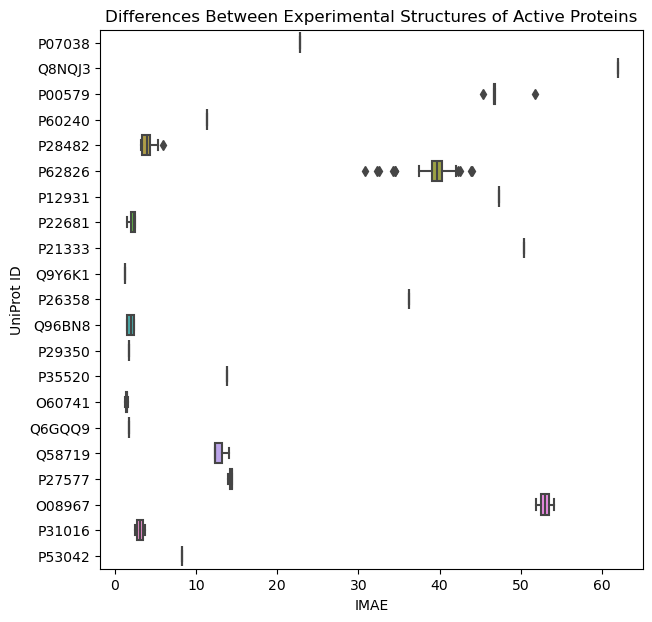

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.boxplot(data=active, x='af_pdb_IMAE', y='uniprot', ax=ax)
ax.set_xlabel('IMAE')
ax.set_ylabel('UniProt ID')
ax.set_title('Differences Between Experimental Structures of Active Proteins')

Text(0.5, 1.0, 'Differences Between Experimental Structures of Autoinhibited Proteins')

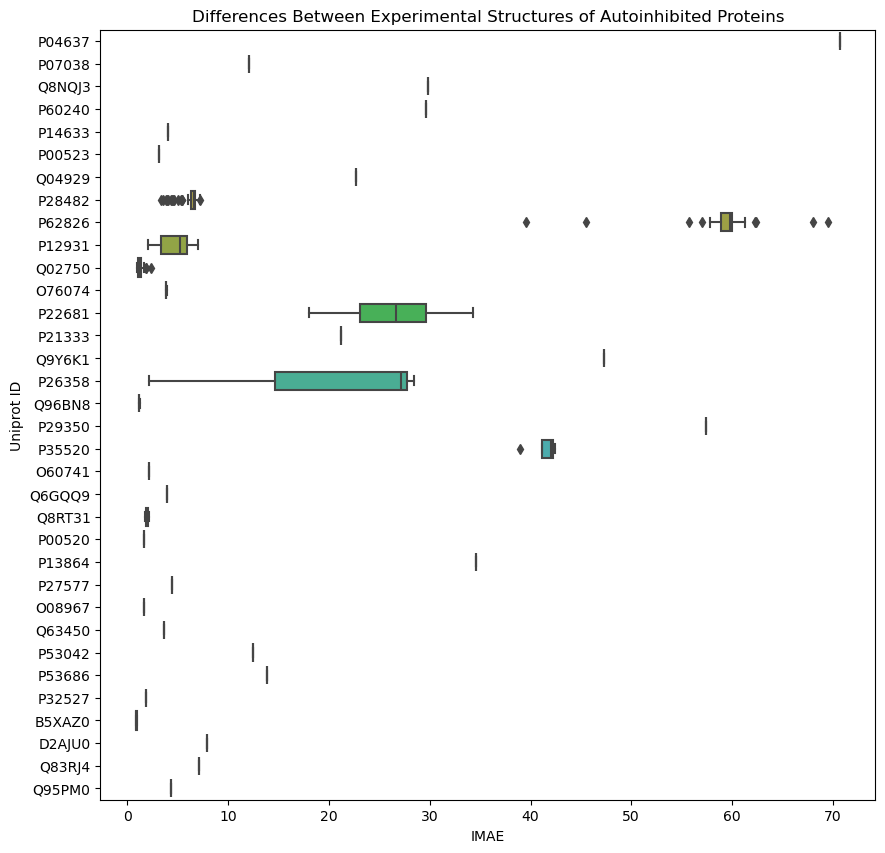

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.boxplot(data=auto, x='af_pdb_IMAE', y='uniprot', ax=ax)
ax.set_xlabel('IMAE')
ax.set_ylabel('Uniprot ID')
ax.set_title('Differences Between Experimental Structures of Autoinhibited Proteins')

In [81]:
# Look at the proteins with many different structures per state
prot = ['P62826', 'P12931', 'P22681', 'P26358', 'P28482', 'P35520']

many = df2[df2['uniprot'].isin(prot)]
print(len(many))
many.head()

257


,uniprot,pdb,region_1,region_2,af_pdb_complex_rmsd,percent_region_1,percent_region_2,2_aligned,af_pdb_IMAE,pdb_state,pdb_conformation,organism,date,notes,chain,af_filename
25,P28482,1pme,173-196,"25-172,197-313",2.422,100.0,96.603774,1.220,6.639,Autoinhibited,Closed,Homo sapiens,['1998-06-08'],NaN,A,F-P28482-F1-model_v3.cif
26,P28482,1tvo,173-196,"25-172,197-313",2.497,100.0,100.000000,1.523,6.633,Autoinhibited,Closed,Homo sapiens,['2004-06-30'],NaN,A,F-P28482-F1-model_v3.cif
27,P28482,1wzy,173-196,"25-172,197-313",2.515,100.0,100.000000,1.768,6.306,Autoinhibited,Closed,Homo sapiens,['2005-03-10'],NaN,A,F-P28482-F1-model_v3.cif
28,P28482,2y9q,173-196,"25-172,197-313",1.967,100.0,100.000000,1.261,4.431,Autoinhibited,Closed,HOMO SAPIENS,['2011-02-16'],NaN,A,F-P28482-F1-model_v3.cif
29,P28482,3sa0,173-196,"25-172,197-313",3.340,100.0,98.867925,1.286,6.758,Autoinhibited,Closed,Homo sapiens,['2011-06-02'],NaN,A,F-P28482-F1-model_v3.cif


In [82]:
def assign_bins(df, bin_size=3):
    bins_info = []

    for protein in df['uniprot'].unique():
        protein_df = df[df['uniprot'] == protein]
        min_val = protein_df['af_pdb_IMAE'].min()
        max_val = protein_df['af_pdb_IMAE'].max()
        bins = np.arange(min_val, max_val + bin_size, bin_size)
        labels = range(len(bins) - 1)

        protein_df['bin'] = pd.cut(protein_df['af_pdb_IMAE'], bins=bins, labels=labels, include_lowest=True)
        protein_df['bin_id'] = protein + '_' + protein_df['bin'].astype('str')

        bins_info.append(protein_df)

    return pd.concat(bins_info)

In [83]:
binned = assign_bins(df2)
binned.head()

/tmp/ipykernel_1143248/214685084.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin'] = pd.cut(protein_df['af_pdb_IMAE'], bins=bins, labels=labels, include_lowest=True)
/tmp/ipykernel_1143248/214685084.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin_id'] = protein + '_' + protein_df['bin'].astype('str')
/tmp/ipykernel_1143248/214685084.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,uniprot,pdb,region_1,region_2,af_pdb_complex_rmsd,percent_region_1,percent_region_2,2_aligned,af_pdb_IMAE,pdb_state,pdb_conformation,organism,date,notes,chain,af_filename,bin,bin_id
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif,NaN,P04637_nan
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif,NaN,P04637_nan
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,Closed,"""Neurospora crassa""",['2002-08-21'],NaN,A,F-P07038-F1-model_v3.cif,3.0,P07038_3
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-18'],“Phosphorylation of Ser913/Thr914 would distur...,A,F-P07038-F1-model_v3.cif,0.0,P07038_0
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-19'],NaN,A,F-P07038-F1-model_v3.cif,0.0,P07038_0


In [84]:
# Check P62826 really quickly, there's some weird stuff going on with one cluster fitting three different bins.
P62826 = binned[binned['uniprot'] == 'P62826']
groupedp = P62826.groupby('bin_id').apply(lambda x: x[x['af_pdb_IMAE'] == x['af_pdb_IMAE'].min()])

groupedp.head(9)

,,uniprot,pdb,region_1,region_2,af_pdb_complex_rmsd,percent_region_1,percent_region_2,2_aligned,af_pdb_IMAE,pdb_state,pdb_conformation,organism,date,notes,chain,af_filename,bin,bin_id
bin_id,,,,,,,,,,,,,,,,,,,
P62826_0,144,P62826,1rrp,179-216,10-169,11.976,86.842105,100.000,1.377,30.840,Active,Closed,Homo sapiens,['1999-01-15'],NaN,A,F-P62826-F1-model_v3.cif,0.0,P62826_0
P62826_1,142,P62826,1k5d,179-216,10-169,13.757,92.105263,100.000,2.235,34.225,Active,Closed,Homo sapiens,['2001-10-10'],NaN,A,F-P62826-F1-model_v3.cif,1.0,P62826_1
P62826_10,230,P62826,7mnv,179-216,10-169,23.383,81.578947,99.375,4.625,61.043,Autoinhibited,Closed,Homo sapiens,['2021-05-01'],NaN,A,F-P62826-F1-model_v3.cif,10.0,P62826_10
P62826_12,145,P62826,2mmc,179-216,10-169,28.197,100.000000,100.000,4.801,68.008,Autoinhibited,Closed,Homo sapiens,['2014-03-13'],NaN,A,F-P62826-F1-model_v3.cif,12.0,P62826_12
P62826_2,231,P62826,7mnw,179-216,10-169,15.482,100.000000,100.000,1.258,37.459,Active,Closed,Homo sapiens,['2021-05-01'],NaN,A,F-P62826-F1-model_v3.cif,2.0,P62826_2
P62826_3,201,P62826,6cit,179-216,10-169,16.150,94.736842,100.000,0.960,39.878,Active,Closed,Homo sapiens,['2018-02-25'],NaN,A,F-P62826-F1-model_v3.cif,3.0,P62826_3
P62826_4,161,P62826,4haw,179-216,10-169,15.494,68.421053,100.000,1.109,43.889,Active,Closed,Homo sapiens,['2012-09-27'],NaN,A,F-P62826-F1-model_v3.cif,4.0,P62826_4
P62826_8,172,P62826,5cj2,179-216,10-169,19.970,68.421053,99.375,4.586,55.712,Autoinhibited,Closed,Homo sapiens,['2015-07-13'],NaN,A,F-P62826-F1-model_v3.cif,8.0,P62826_8
P62826_9,170,P62826,5cit,179-216,10-169,21.438,73.684211,100.000,4.847,58.062,Autoinhibited,Closed,Homo sapiens,['2015-07-13'],NaN,A,F-P62826-F1-model_v3.cif,9.0,P62826_9


In [85]:
# We need only uniprot, pdb, state, conformation, and bin_id
binned_s = binned[['uniprot', 'pdb', 'pdb_state', 'pdb_conformation', 'bin_id']]

merge1 = pd.merge(binned_s, df1, on=['uniprot', 'pdb', 'pdb_state', 'pdb_conformation'], how='inner')
merge1.head()

KeyError: 'pdb_state'

So all of our best structures are from uniformly sampled MSAs. Let's see what happens without those in the mix.

43
43


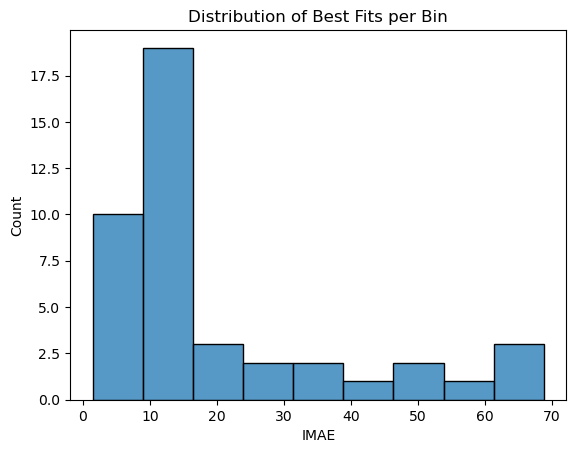

In [ ]:
nou = merge1[~merge1['cluster'].str.contains('U')]
nou = nou[nou['cf_pdb_IMAE'] > 0]

best2 = nou.groupby('bin_id').apply(lambda x: x[x['cf_pdb_IMAE'] == x['cf_pdb_IMAE'].min()]).drop_duplicates(subset='bin_id', keep='first')
print(len(best2))
print(best2['bin_id'].nunique())

sns.histplot(best2, x='cf_pdb_IMAE')
plt.title('Distribution of Best Fits per Bin')
plt.xlabel('IMAE')

plt.savefig('./project_pipeline/data/figures/best_fits_per_structure_clump.png', dpi=300)

In [ ]:
best2.head()

uniprot   pdb      pdb_state pdb_conformation     bin_id  \
bin_id                                                                      
O08967_0  102879  O08967  2r09  Autoinhibited           Closed   O08967_0   
          102880  O08967  2r09  Autoinhibited           Closed   O08967_0   
O08967_16 103037  O08967  6bbp         Active           Closed  O08967_16   
          103038  O08967  6bbp         Active           Closed  O08967_16   
O08967_17 103151  O08967  6bbq         Active           Closed  O08967_17   

                 cluster         region_1 region_2  cf_pdb_complex_rmsd  \
bin_id                                                                    
O08967_0  102879     005  251-265,383-395   77-206               16.731   
          102880     005  251-265,383-395   77-206               16.731   
O08967_16 103037     016  251-265,383-395   77-206               23.985   
          103038     016  251-265,383-395   77-206               23.985   
O08967_17 103151     016  251-265,383-395   77-206               26.472   

                  1.0_aligned  ...  2.1_aligned  2.1_comp  2.2_aligned  \
bin_id                         ...                                       
O08967_0  102879          0.0  ...          0.0       0.0          0.0   
          102880          0.0  ...          0.0       0.0          0.0   
O08967_16 103037          0.0  ...          0.0       0.0          0.0   
          103038          0.0  ...          0.0       0.0          0.0   
O08967_17 103151          0.0  ...          0.0       0.0          0.0   

                  2.2_comp  2.3_aligned  2.3_comp  1_aligned  1_comp  \
bin_id                                                                 
O08967_0  102879       0.0            0         0      3.111  16.227   
          102880       0.0            0         0      3.111  16.227   
O08967_16 103037       0.0            0         0      0.575  55.331   
          103038       0.0            0         0      0.575  55.331   
O08967_17 103151       0.0            0         0      0.575  49.851   

                  2_aligned  cf_pdb_IMAE  
bin_id                                    
O08967_0  102879      4.053        7.670  
          102880      4.053        7.670  
O08967_16 103037      8.792       38.408  
          103038      8.792       38.408  
O08967_17 103151      8.792       42.161  

[5 rows x 27 columns]

In [ ]:
best2_sub = best2[['uniprot', 'pdb', 'pdb_state', 'pdb_conformation', 'cf_pdb_complex_rmsd', 'cf_pdb_IMAE', 'cluster']].reset_index()
best2_sub = best2_sub.drop(columns=['level_1'])
best3 = pd.merge(best2_sub, df3, on=['uniprot', 'cluster'], how='inner').drop_duplicates()
best3['cluster_id'] = best3['uniprot'] + '_' + best3['cluster']
print(len(best3))
print(best3['cluster_id'].nunique())
best3.head()

44
33


,bin_id,uniprot,pdb,pdb_state,pdb_conformation,cf_pdb_complex_rmsd,cf_pdb_IMAE,cluster,region_1,region_2,cf_filename,interacting_residue_pairs,interface_residues,number_interface_residues,region_1 search,region_2 search,cf_conformation,cluster_id
0,O08967_0,O08967,2r09,Autoinhibited,Closed,16.731,7.670,005,"251-265,383-395",77-206,O08967_005_unrelaxed_rank_003_alphafold2_multi...,"[(159, 261), (162, 262), (166, 394), (195, 262...","{384, 258, 387, 388, 261, 262, 391, 392, 264, ...",39.0,"[256, 257, 258, 259, 260, 261, 262, 263, 264, ...","[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 8...",Closed,O08967_005
2,O08967_16,O08967,6bbp,Active,Closed,23.985,38.408,016,"251-265,383-395",77-206,O08967_016_unrelaxed_rank_001_alphafold2_multi...,"[(159, 261), (205, 259), (195, 262), (199, 263...","{256, 257, 258, 259, 261, 262, 263, 264, 153, ...",30.0,"[256, 257, 258, 259, 260, 261, 262, 263, 264, ...","[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 8...",Closed,O08967_016
4,O08967_17,O08967,6bbq,Active,Closed,26.472,42.161,016,"251-265,383-395",77-206,O08967_016_unrelaxed_rank_001_alphafold2_multi...,"[(159, 261), (205, 259), (195, 262), (199, 263...","{256, 257, 258, 259, 261, 262, 263, 264, 153, ...",30.0,"[256, 257, 258, 259, 260, 261, 262, 263, 264, ...","[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 8...",Closed,O08967_016
6,O60741_0,O60741,5u6o,Autoinhibited,Closed,20.648,26.541,000,401-479,480-604,O60741_000_unrelaxed_rank_002_alphafold2_multi...,"[(473, 515), (466, 493), (478, 480), (469, 488...","{513, 515, 518, 520, 458, 459, 463, 466, 469, ...",27.0,"[401, 402, 403, 404, 405, 406, 407, 408, 409, ...","[480, 481, 482, 483, 484, 485, 486, 487, 488, ...",Closed,O60741_000
7,P07038_0,P07038,7nxf,Autoinhibited,Closed,27.439,57.027,001,892-917,562-625,P07038_001_unrelaxed_rank_002_alphafold2_multi...,NaN,NaN,NaN,"[892, 893, 894, 895, 896, 897, 898, 899, 900, ...","[562, 563, 564, 565, 566, 567, 568, 569, 570, ...",Open,P07038_001


In [ ]:
best3_sub = best3[['cluster_id', 'cf_conformation']].drop_duplicates(subset='cluster_id', keep='first')
print(best3_sub['cf_conformation'].value_counts())

best3_pdb_sub = best3[['pdb', 'pdb_conformation']].drop_duplicates()
print(best3_pdb_sub['pdb_conformation'].value_counts())

Closed    28
Open       5
Name: cf_conformation, dtype: int64
Closed    42
Open       2
Name: pdb_conformation, dtype: int64
uniprot  cf_conformation
O08967   Closed             3
O60741   Closed             1
P07038   Open               3
P12931   Closed             3
P22681   Closed             6
P27577   Closed             2
P28482   Closed             2
P29350   Closed             1
         Open               1
P35520   Closed             3
P53042   Closed             2
P60240   Open               2
P62826   Closed             9
Q6GQQ9   Closed             1
Q8NQJ3   Closed             1
         Open               1
Q96BN8   Closed             1
Q9Y6K1   Closed             2
Name: cf_conformation, dtype: int64


In [ ]:
best3unig = best3.groupby(['uniprot'])['cf_conformation'].value_counts()
best3unig = best3unig.unstack(fill_value=0).reset_index()
best3unig.columns.name = None
best3unig = best3unig.rename(columns={'Closed': 'Closed Cluster', 'Open': 'Open Cluster'})
best3unig.head(16)

,uniprot,Closed Cluster,Open Cluster
0,O08967,3,0
1,O60741,1,0
2,P07038,0,3
3,P12931,3,0
4,P22681,6,0
5,P27577,2,0
6,P28482,2,0
7,P29350,1,1
8,P35520,3,0
9,P53042,2,0


In [ ]:
best3_pdb_unig = best3.groupby(['uniprot'])['pdb_conformation'].value_counts()
best3_pdb_unig = best3_pdb_unig.unstack(fill_value=0).reset_index()
best3_pdb_unig.columns.name = None
best3_pdb_unig = best3_pdb_unig.rename(columns={'Closed': 'Closed Experimental', 'Open': 'Open Experimental'})
best3_pdb_unig.head(16)

,uniprot,Closed Experimental,Open Experimental
0,O08967,3,0
1,O60741,1,0
2,P07038,3,0
3,P12931,3,0
4,P22681,6,0
5,P27577,2,0
6,P28482,2,0
7,P29350,2,0
8,P35520,3,0
9,P53042,2,0


In [ ]:
best3_af = pd.merge(best3, df4_sub, on=['uniprot'], how='inner')
best3_af = best3_af[['uniprot', 'af_conformation']].drop_duplicates()
best3_af = best3_af.groupby(['uniprot'])['af_conformation'].value_counts()
best3_af = best3_af.unstack(fill_value=0).reset_index()
best3_af.columns.name = None
best3_af = best3_af.rename(columns={'Closed': 'Closed Full-Depth', 'Open': 'Open Full-Depth'})
best3_af.head(16)

,uniprot,Closed Full-Depth,Open Full-Depth
0,O08967,1,0
1,O60741,1,0
2,P07038,1,0
3,P12931,1,0
4,P22681,1,0
5,P27577,1,0
6,P28482,1,0
7,P29350,1,0
8,P35520,1,0
9,P53042,1,0


In [ ]:
best3_merge = pd.merge(best3unig, best3_pdb_unig, on=['uniprot'], how='inner')
best3_merge = pd.merge(best3_merge, best3_af, on=['uniprot'], how='inner')
best3_merge.head(16)

,uniprot,Closed Cluster,Open Cluster,Closed Experimental,Open Experimental,Closed Full-Depth,Open Full-Depth
0,O08967,3,0,3,0,1,0
1,O60741,1,0,1,0,1,0
2,P07038,0,3,3,0,1,0
3,P12931,3,0,3,0,1,0
4,P22681,6,0,6,0,1,0
5,P27577,2,0,2,0,1,0
6,P28482,2,0,2,0,1,0
7,P29350,1,1,2,0,1,0
8,P35520,3,0,3,0,1,0
9,P53042,2,0,2,0,1,0


In [ ]:
best3g = best3.groupby(['cluster_id'])['cf_conformation'].value_counts()
best3g = best3g.unstack(fill_value=0).reset_index()
best3g.columns.name = None
best3g = best3g.rename(columns={'Closed': 'Closed Cluster', 'Open': 'Open Cluster'})
best3g.head(33)

,cluster_id,Closed Cluster,Open Cluster
0,O08967_005,1,0
1,O08967_016,2,0
2,O60741_000,1,0
3,P07038_000,0,1
4,P07038_001,0,2
5,P12931_001,2,0
6,P12931_018,1,0
7,P22681_001,2,0
8,P22681_004,1,0
9,P22681_007,1,0


In [ ]:
acceptable2 = best2[best2['cf_pdb_IMAE'] <= 3]
acceptable2.head()

,,uniprot,pdb,pdb_state,pdb_conformation,bin_id,cluster,region_1,region_2,cf_pdb_complex_rmsd,1.0_aligned,...,2.1_aligned,2.1_comp,2.2_aligned,2.2_comp,2.3_aligned,2.3_comp,1_aligned,1_comp,2_aligned,cf_pdb_IMAE
bin_id,,,,,,,,,,,,,,,,,,,,,,
P28482_0,59049,P28482,7opm,Autoinhibited,Closed,P28482_0,000,173-196,"25-172,197-313",2.354,2.460,...,1.043,2.594,1.168,2.918,0,0,2.460,2.153,1.105,2.756
P62826_8,79348,P62826,5cj2,Autoinhibited,Closed,P62826_8,096,179-216,10-169,1.978,1.194,...,0.000,0.000,0.000,0.000,0,0,1.194,2.230,2.078,1.552
P62826_9,79096,P62826,5cit,Autoinhibited,Closed,P62826_9,096,179-216,10-169,1.887,1.037,...,0.000,0.000,0.000,0.000,0,0,1.037,2.721,1.981,1.466
Q96BN8_0,99035,Q96BN8,6sak,NaN,Closed,Q96BN8_0,013,330-340,129-341,3.333,1.012,...,0.000,0.000,0.000,0.000,0,0,1.012,4.697,3.229,1.756


In [ ]:
df3_sub = df3[['uniprot', 'cluster', 'cf_conformation']]
acceptable2 = pd.merge(acceptable2, df3_sub, on=['uniprot', 'cluster'], how='left').drop_duplicates(subset=['uniprot', 'pdb', 'cluster'])
acceptable2.head(10)

,uniprot,pdb,pdb_state,pdb_conformation,bin_id,cluster,region_1,region_2,cf_pdb_complex_rmsd,1.0_aligned,...,2.1_comp,2.2_aligned,2.2_comp,2.3_aligned,2.3_comp,1_aligned,1_comp,2_aligned,cf_pdb_IMAE,cf_conformation
0,P28482,7opm,Autoinhibited,Closed,P28482_0,000,173-196,"25-172,197-313",2.354,2.460,...,2.594,1.168,2.918,0,0,2.460,2.153,1.105,2.756,Closed
1,P62826,5cj2,Autoinhibited,Closed,P62826_8,096,179-216,10-169,1.978,1.194,...,0.000,0.000,0.000,0,0,1.194,2.230,2.078,1.552,Closed
2,P62826,5cit,Autoinhibited,Closed,P62826_9,096,179-216,10-169,1.887,1.037,...,0.000,0.000,0.000,0,0,1.037,2.721,1.981,1.466,Closed
3,Q96BN8,6sak,NaN,Closed,Q96BN8_0,013,330-340,129-341,3.333,1.012,...,0.000,0.000,0.000,0,0,1.012,4.697,3.229,1.756,Closed


In [ ]:
acceptable2 = acceptable2[['uniprot', 'pdb', 'pdb_state', 'pdb_conformation', 'bin_id', 'complex_rmsd', 'cf_pdb_IMAE', 'cf_conformation', 'af_state', 'af_conformation']]
acceptable2 = acceptable2.rename(columns={'cf_conformation': 'Cluster Conformation', 'af_state': 'Full-Depth State', 'af_conformation': 'Full-Depth Conformation',
                                          'pdb_state': 'Experimental State', 'pdb_conformation': 'Experimental Conformation', 'cf_pdb_IMAE': 'IMAE', 'complex_rmsd': 'Complex RMSD'})
acceptable2.head()

KeyError: "['complex_rmsd', 'af_state', 'af_conformation'] not in index"